In [56]:
from sympy import symbols, solve, lambdify, sympify, dsolve, Eq, solveset
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import quiver

from ipywidgets import widgets
from IPython.display import clear_output, display

In [40]:
x, y = symbols('x y')

In [41]:
expr1 = 2*x - y + 3*(x**2 - y**2) + 2*x*y
expr1

3*x**2 + 2*x*y + 2*x - 3*y**2 - y

In [42]:
expr2 = x - 3*y - 3*(x**2-y**2) + 3*x*y
expr2

-3*x**2 + 3*x*y + x + 3*y**2 - 3*y

In [43]:
f1 = lambdify((x, y), expr1)
f2 = lambdify((x, y), expr2)

In [6]:
num_arrows_slider = widgets.IntSlider()
display(num_arrows_slider)
num_arrows = num_arrows_slider.value

Widget Javascript not detected.  It may not be installed or enabled properly.


In [61]:
def plotEquation (eq, solvar, plotvar, inputrange):
    '''
        Given a sympy equation object `eq`, this function return a series of values,
        in the range of `inputrange` such that the equation is solved for
        `solvar` and the input is for `plotvar`
    '''
    eq = Eq(eq, 0)
    sol = solve(eq, solvar)
    vals = []
    for s in sol:
        f = lambdify((plotvar), sol)
        vals.append([f(i) for i in inputrange])
    return vals

In [36]:
# def solveEquations():
    

In [52]:
def on_change():
    clear_output()
    
    yrange = np.linspace(y_range_slider.value[0], y_range_slider.value[1])
    xrange = np.linspace(x_range_slider.value[0], x_range_slider.value[1])
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlim([min(xrange), max(xrange)])
    ax.set_ylim([min(yrange), max(yrange)])
    
    f1_val = [[f1(i, j) for i in xrange] for j in yrange];
    f2_val = [[f2(i, j) for i in xrange] for j in yrange];

    q = ax.quiver(xrange, yrange, f1_val, f2_val)

    solutions = solve([expr1,expr2], (x,y))
    try:
        [ax.scatter(i[0], i[1]) for i in solutions];
    except:
        print('Some roots are complex')

    try:
        [ax.plot(yrange, nc, c='b') for nc in plotEquation(expr1, y, x, yrange)]
        [ax.plot(nc, xrange, c='r') for nc in plotEquation(expr2, x, y, xrange)]
    except:
        print('Some nullcline values are complex')

    plt.show()

Some roots are complex


<lambdifygenerated-207>:2: RuntimeWarning: invalid value encountered in sqrt
  return ([(1/3)*x - 1/6*sqrt(40*x**2 + 20*x + 1) - 1/6, (1/3)*x + (1/6)*sqrt(40*x**2 + 20*x + 1) - 1/6])
<lambdifygenerated-208>:2: RuntimeWarning: invalid value encountered in sqrt
  return ([(1/3)*x - 1/6*sqrt(40*x**2 + 20*x + 1) - 1/6, (1/3)*x + (1/6)*sqrt(40*x**2 + 20*x + 1) - 1/6])
<lambdifygenerated-209>:2: RuntimeWarning: invalid value encountered in sqrt
  return ([(1/2)*y - 1/6*sqrt(45*y**2 - 30*y + 1) + 1/6, (1/2)*y + (1/6)*sqrt(45*y**2 - 30*y + 1) + 1/6])
<lambdifygenerated-210>:2: RuntimeWarning: invalid value encountered in sqrt
  return ([(1/2)*y - 1/6*sqrt(45*y**2 - 30*y + 1) + 1/6, (1/2)*y + (1/6)*sqrt(45*y**2 - 30*y + 1) + 1/6])


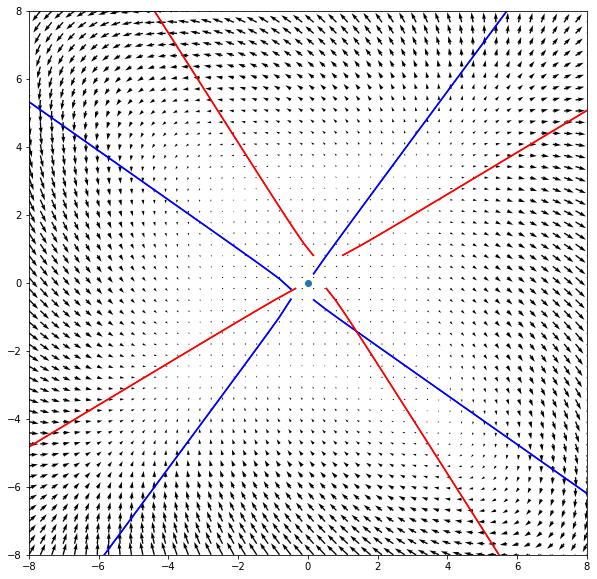

In [60]:
y_range_slider = widgets.IntRangeSlider(min=-10, max=10)
display(y_range_slider)

x_range_slider = widgets.IntRangeSlider(min=-10, max=10)
display(x_range_slider)

# y_range_slider.observe(on_change)
# x_range_slider.observe(on_change)

renderButton = widgets.Button(description='Plot')
display(renderButton)

@renderButton.on_click
def renderButtonOnClick(b):
    on_change()


In [59]:
? solve

In [58]:
solve([expr1,expr2], (x,y), real=True)

[(0, 0),
 (-(-1/3 - 16/(15*(-1/2 - sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3)) - (-1/2 - sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3)/3)*(-83 - 32/((-1/2 - sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3)) + 75*(-1/3 - 16/(15*(-1/2 - sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3)) - (-1/2 - sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3)/3)**2 - 10*(-1/2 - sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3))/36,
  -1/3 - 16/(15*(-1/2 - sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3)) - (-1/2 - sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3)/3),
 (-(-1/3 - (-1/2 + sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3)/3 - 16/(15*(-1/2 + sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3)))*(-83 - 10*(-1/2 + sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3) + 75*(-1/3 - (-1/2 + sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3)/3 - 16/(15*(-1/2 + sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3)))**2 - 32/((-1/2 + sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3)))/36,
  -1/3 - (-1/2 + sqrt(3)*I/2)*(8/5 + 8*sqrt(295)*I/25)**(1/3)/3 - 16/(15*(-1